In [1]:
import sys

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

sys.path.append('../src')
from data_utils import UnlearningDataLoader
import subprocess
import time
import warnings
from datetime import datetime

import mlflow
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import LambdaLR

from config import set_config
from data_utils import UnlearningDataLoader
from eval import (
    compute_accuracy,
    get_forgetting_rate,
    get_js_div,
    get_l2_params_distance,
    mia,
)
from mlflow_utils import mlflow_tracking_uri
from models import VGG19, AllCNN, ResNet18, ViT
from seed import set_seed
from unlearning_class import UnlearningClass
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/home/cspartalis/anaconda3/envs/MaUn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Args
run_id = "149b43f9c3414f889e9f768b79d729c2"
mlflow.set_tracking_uri(mlflow_tracking_uri)

In [3]:
# Setup
# Load params from retraining run
retrain_run = mlflow.get_run(run_id)
seed = int(retrain_run.data.params["seed"])
dataset = retrain_run.data.params["dataset"]
model_str = retrain_run.data.params["model"]
batch_size = int(retrain_run.data.params["batch_size"])
epochs_to_retrain = int(retrain_run.data.metrics["best_epoch"])
loss_str = retrain_run.data.params["loss"]
optimizer_str = retrain_run.data.params["optimizer"]
momentum = float(retrain_run.data.params["momentum"])
weight_decay = float(retrain_run.data.params["weight_decay"])
acc_forget_retrain = int(retrain_run.data.metrics["acc_forget"])

In [4]:
# Load data
UDL = UnlearningDataLoader(dataset, batch_size, seed)
dl, dataset_sizes = UDL.load_data()
num_classes = len(UDL.classes)
input_channels = UDL.input_channels
image_size = UDL.image_size

Files already downloaded and verified
Files already downloaded and verified


In [5]:
forget_dataset = dl["forget"].dataset
retain_dataset = dl["retain"].dataset

In [6]:
forget_flattened = []
forget_target = []
retain_flattened = []
retain_target = []

for data, target in forget_dataset:
    forget_flattened.append(data.reshape(1, -1))
    forget_target.append(target)

forget_flattened = torch.cat(forget_flattened, dim=0)
forget_target = torch.tensor(forget_target)

for data, target in retain_dataset:
    retain_flattened.append(data.reshape(1, -1))
    retain_target.append(target)

retain_flattened = torch.cat(retain_flattened, dim=0)
retain_target = torch.tensor(retain_target)

In [7]:
def perform_pca(data):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(data)
    return transformed_data


In [8]:
transformed_forget = perform_pca(forget_flattened.numpy())
transformed_retain = perform_pca(retain_flattened.numpy())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


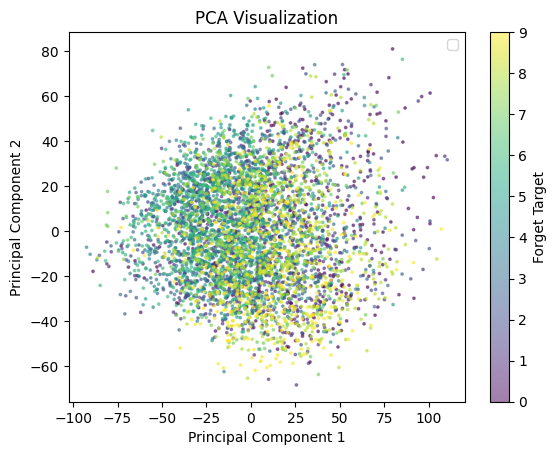

<Figure size 1000x800 with 0 Axes>

In [9]:
plt.scatter(transformed_forget[:, 0], transformed_forget[:, 1], c=forget_target, cmap='viridis', s=3, alpha=0.5)
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.colorbar(label='Forget Target')
plt.figure(figsize=(10, 8))
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


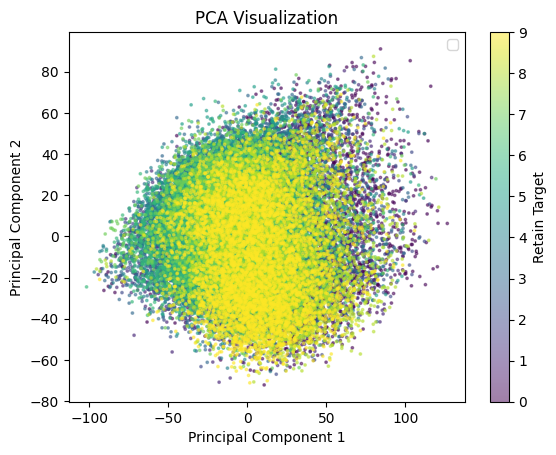

In [10]:
plt.scatter(transformed_retain[:, 0], transformed_retain[:, 1], c=retain_target, cmap='viridis', s=3, alpha=0.5)
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.colorbar(label='Retain Target')
plt.show()

In [11]:
def perform_tsne(data):
    tsne = TSNE(n_components=2)
    transformed_data = tsne.fit_transform(data)
    return transformed_data


In [12]:
tsne_forget = perform_tsne(forget_flattened.numpy())
tsne_retain = perform_tsne(retain_flattened.numpy())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


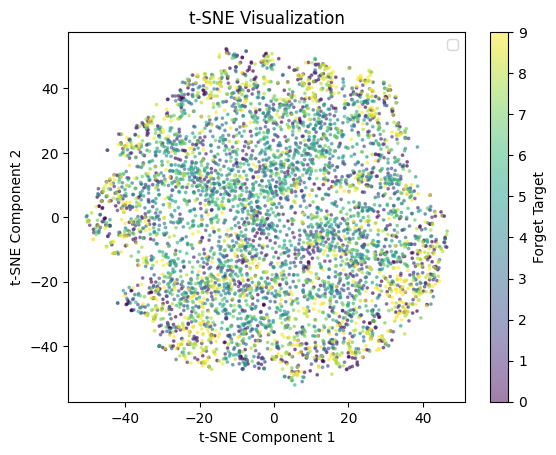

<Figure size 1000x800 with 0 Axes>

In [13]:
plt.scatter(tsne_forget[:, 0], tsne_forget[:, 1], c=forget_target, cmap='viridis', s=3, alpha=0.5)
plt.legend()
plt.xlabel('t-SNE Component 1')  # Updated xlabel name
plt.ylabel('t-SNE Component 2')  # Updated ylabel name
plt.title('t-SNE Visualization')
plt.colorbar(label='Forget Target')
plt.figure(figsize=(10, 8))
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


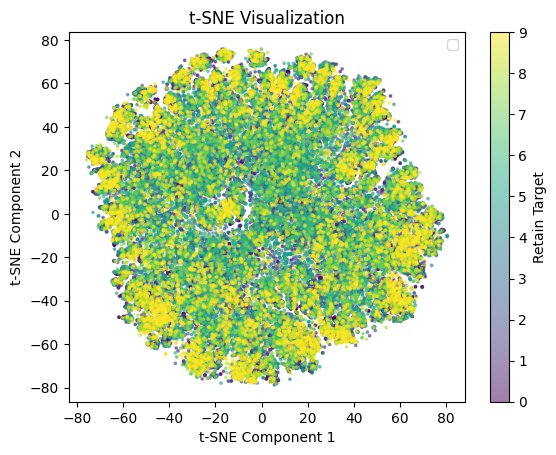

<Figure size 1000x800 with 0 Axes>

In [14]:
plt.scatter(tsne_retain[:, 0], tsne_retain[:, 1], c=retain_target, cmap='viridis', s=3, alpha=0.5)
plt.legend()
plt.xlabel('t-SNE Component 1')  # Updated xlabel name
plt.ylabel('t-SNE Component 2')  # Updated ylabel name
plt.title('t-SNE Visualization')
plt.colorbar(label='Retain Target')
plt.figure(figsize=(10, 8))
plt.show()

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the number of samples per class
samples_per_class = 300

# Create the StratifiedShuffleSplit object
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=samples_per_class, random_state=42)

# Perform stratified sampling on forget_flattened
forget_indices = []
for _, indices in stratified_split.split(forget_flattened, forget_target):
    forget_indices.extend(indices)

# Perform stratified sampling on retain_flattened
retain_indices = []
for _, indices in stratified_split.split(retain_flattened, retain_target):
    retain_indices.extend(indices)

# Get the stratified samples from forget_flattened and retain_flattened
forget_points30 = forget_flattened[forget_indices]
forget_targets30 = forget_target[forget_indices]
retain_points30 = retain_flattened[retain_indices]
retain_targets30 = retain_target[retain_indices]


In [16]:
import torchvision.datasets as datasets

# Load CIFAR-10 dataset
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True)

# Get the class names
class_names = cifar10_dataset.classes


Files already downloaded and verified


In [17]:
forget_points30_pca = perform_pca(forget_points30.numpy())
retain_points30_pca = perform_pca(retain_points30.numpy())

In [18]:
print(forget_points30_pca.shape)
print(retain_points30_pca.shape)

(300, 2)
(300, 2)


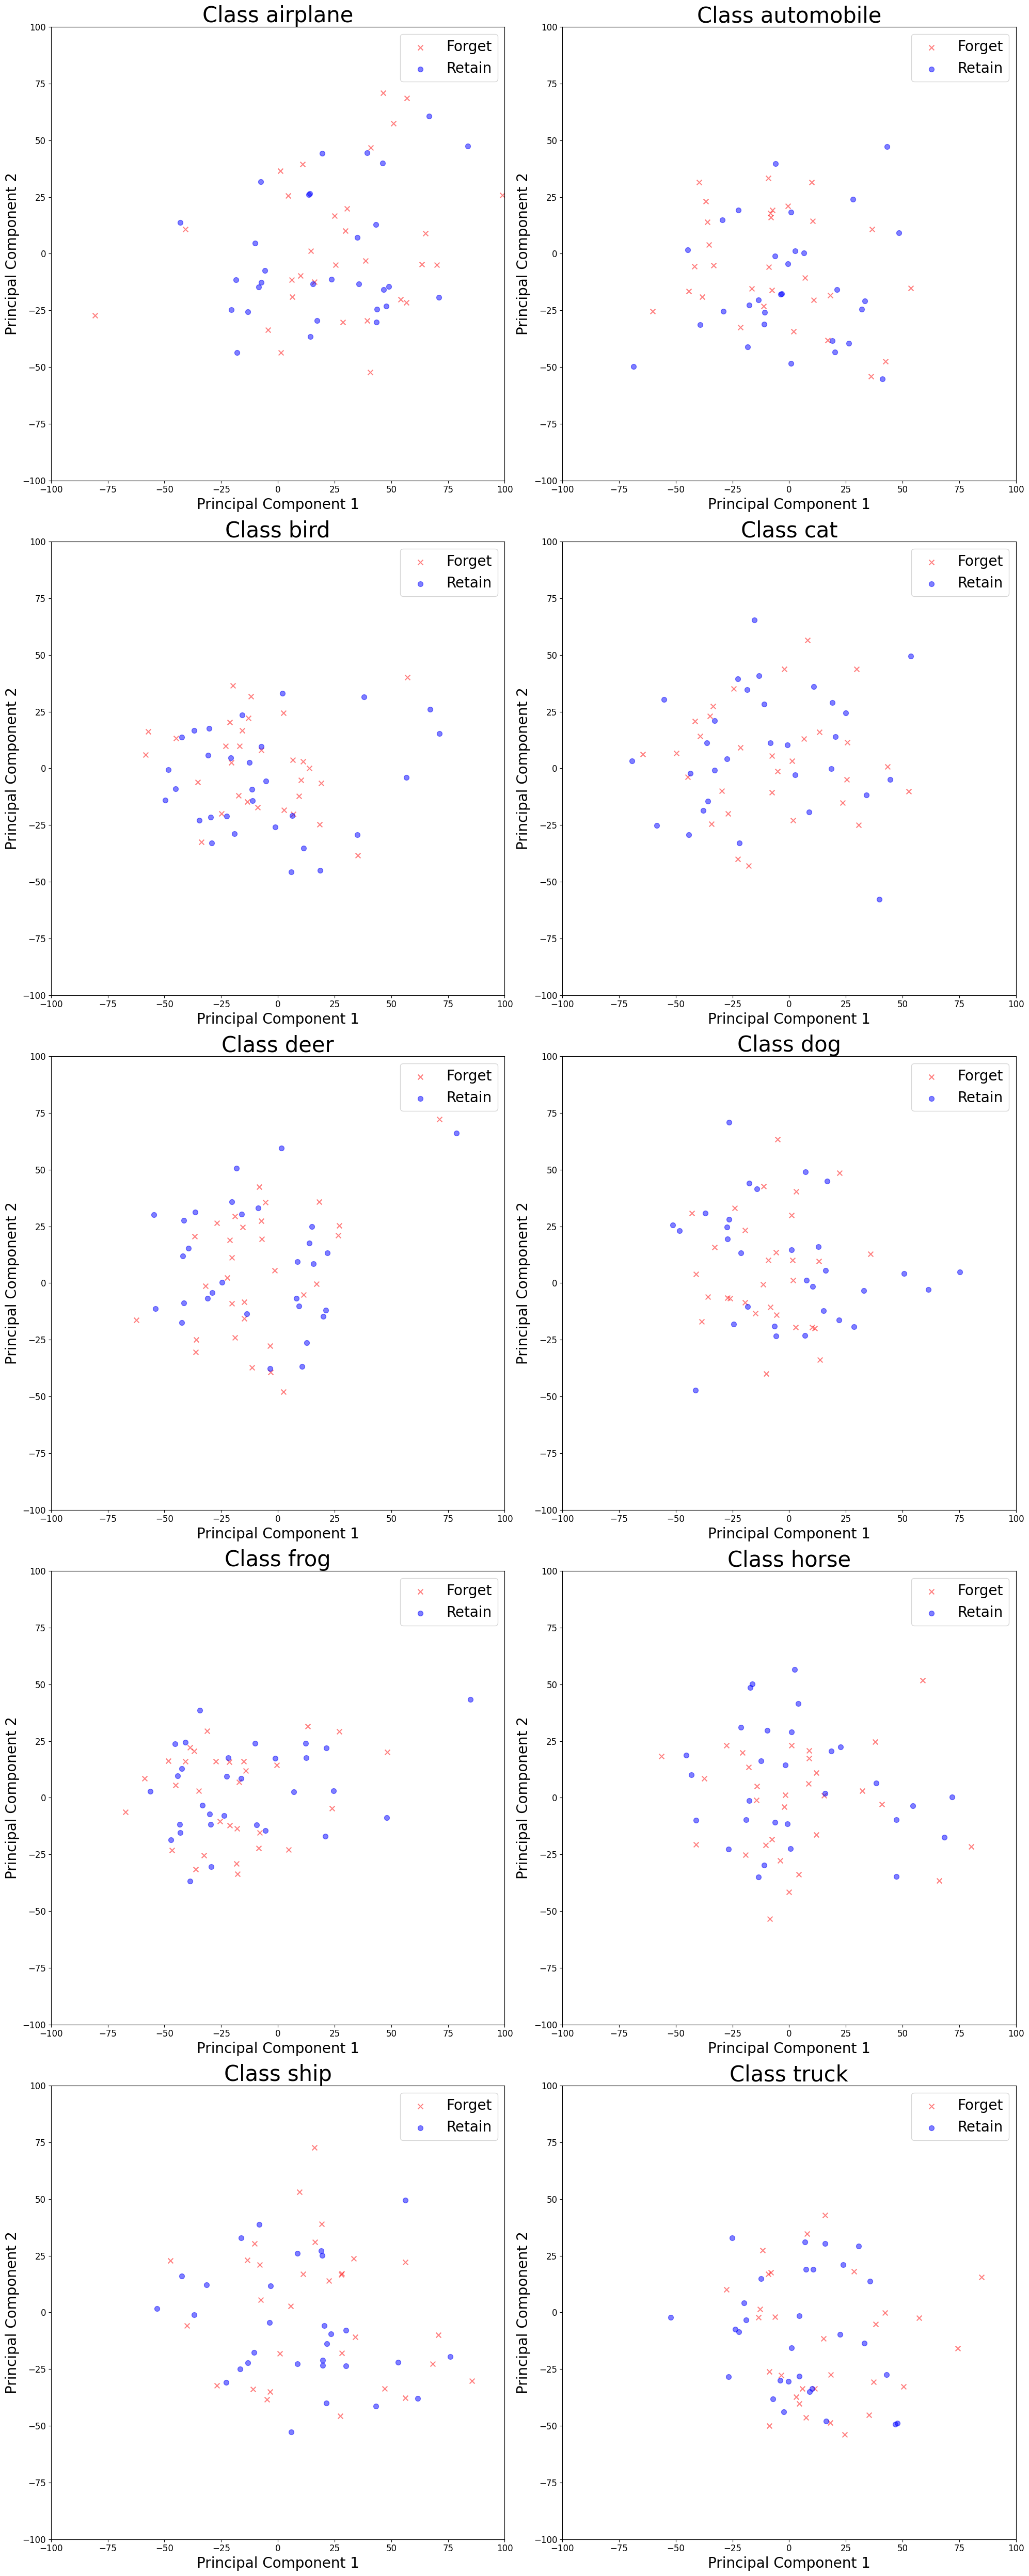

In [27]:
fig, axs = plt.subplots(5, 2, figsize=(20, 50))

for i, ax in enumerate(axs.flat):
    forget_class_points = forget_points30_pca[forget_targets30 == i]
    retain_class_points = retain_points30_pca[retain_targets30 == i]
    
    ax.scatter(forget_class_points[:, 0], forget_class_points[:, 1], c='red', s=50, alpha=0.5, marker='x', label='Forget')
    ax.scatter(retain_class_points[:, 0], retain_class_points[:, 1], c='blue', s=50, alpha=0.5, marker='o', label='Retain')
    
    ax.legend(fontsize=20)
    ax.set_xlabel('Principal Component 1', fontsize=20)
    ax.set_ylabel('Principal Component 2', fontsize=20)
    ax.set_title(f'Class {class_names[i]}', fontsize=30)
    
    ax.set_aspect('equal')  # Set the aspect ratio to be equal
    ax.set_xlim([-100, 100])  # Set the x-axis limit
    ax.set_ylim([-100, 100])  # Set the y-axis limit
    ax.tick_params(axis='both', which='major', labelsize=12)  # Increase font size and ticks

plt.tight_layout()
plt.show()

In [20]:
cov_matrix = np.cov(retain_points30_pca.T)
print(cov_matrix)

[[ 1.03927357e+03 -1.54442078e-06]
 [-1.54442078e-06  7.06314193e+02]]


In [21]:
cov_matrix = np.cov(forget_points30_pca.T)
print(cov_matrix)

[[9.68483233e+02 5.31010689e-06]
 [5.31010689e-06 6.76424330e+02]]
